To reproduce this example, you need to register to Insee’s API and
configure `pynsee`. Go check [Section 5](#sec-config) for details.

## Dependencies

In [1]:
import geopandas
import pandas as pd
import numpy as np
import pyproj
from shapely.ops import transform

import matplotlib.pyplot as plt
import matplotlib, descartes
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

import pynsee

## Getting data

We will use two functions to get businesses datasets :

-   `pynsee.get_activity_list` to get relevent classification
-   `pynsee.search_sirene` to find car industry (SIRET with *‘29.10Z’*)

In [2]:
# get activity list
naf5 = pynsee.get_activity_list('NAF5')

# search data in SIRENE database
data = pynsee.search_sirene(variable = "activitePrincipaleEtablissement",
                   pattern = '29.10Z', kind = 'siret')

Locally saved data has been used
Set update=True to trigger an update
Locally saved legal data has been used
Set update=True to trigger an update

We also want to automatically retrieve administration borders at
*departement* level. We can use :

-   `pynsee.get_geodata` to retrieve borders
-   `translate` method to put French islands (DROM) close to France
    metropolitan area

<AxesSubplot:>

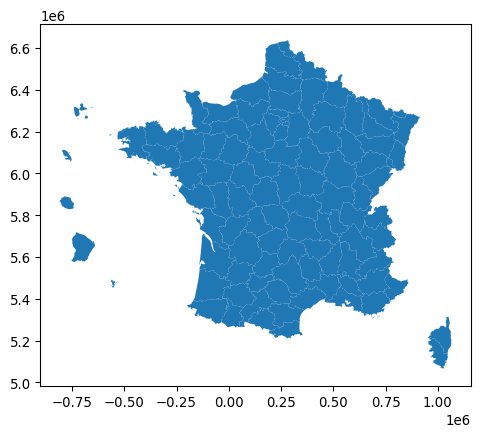

In [3]:
# get map - departement limits
geodataList =  pynsee.get_geodata_list()
mapdep = pynsee.get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
mapdep = mapdep.translate()

# conversion to geopandas df
mapdepgeo = geopandas.GeoDataFrame(mapdep)
mapdepgeo.plot()

## Feature processing

We will keep only businesses with more then 100 employees

In [4]:
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)

`df` is a `pandas DataFrame` supercharged with a few convenient methods.
One of them is `get_location` that helps finding longitude and latitudes
of businesses:

In [5]:
# find latitude and longitude of all businesses
df = df.get_location()

Getting location:   0%|                                                                                                                 | 0/44 [00:00<?, ?it/s]Getting location:   2%|██▍                                                                                                      | 1/44 [00:00<00:28,  1.51it/s]Getting location:   5%|████▊                                                                                                    | 2/44 [00:01<00:23,  1.82it/s]Getting location:   7%|███████▏                                                                                                 | 3/44 [00:01<00:22,  1.85it/s]Getting location:   9%|█████████▌                                                                                               | 4/44 [00:02<00:21,  1.86it/s]Getting location:  11%|███████████▉                                                                                             | 5/44 [00:02<00:19,  1.98it/s]Getting location:  14%|██████████████▎        

We finally transform that in `geopandas.GeoDataFrame` to prepare a map.

In [6]:
# make geodataframe
gdf = geopandas.GeoDataFrame(df)
gdf = gdf.reset_index(drop=True)
gdf = gdf.sort_values(by=['effectifsMinEtablissement'], ascending=False)

Let’s keep the following list of car constructors:

In [7]:
# make cleaned labels
match_list = ['RENAULT SAS', 'ALPINE', 'BATILLY', 'MAUBEUGE CONSTRUCTION',
              'TOYOTA', 'PSA AUTOMOBILES', 'VEHICULES LEGERS DU NORD', 'RENAULT TRUCKS']

In [8]:
other_string_list = '|'.join(['[^' + x + ']' for x in match_list])
conditions = [gdf['denominationUniteLegale'].str.contains(x) for x in match_list]
conditions += [gdf['denominationUniteLegale'].str.contains(other_string_list)]
values = ['RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS',
          'TOYOTA', 'PSA AUTOMOBILES','PSA AUTOMOBILES', 'RENAULT TRUCKS', 'OTHER']

gdf['label'] = np.select(conditions, values)

In [9]:
gdf = gdf.set_crs(4326).to_crs(3857)

## Map

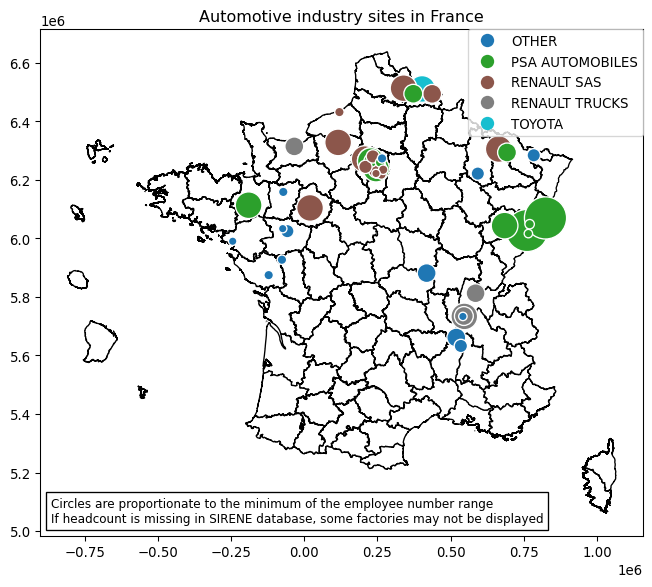

In [10]:
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdepgeo.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax,
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)

plt.show()

## Prerequisite

-   Subscribe to https://api.insee.fr/catalogue/ and get your
    credentials!
-   Save your credentials with `init_conn` function :

In [11]:
# Initialize key
from pynsee.utils.init_conn import init_conn
#init_conn(insee_key="my_insee_key", insee_secret="my_insee_secret")

-   Beware : any change to the keys should be tested after having
    cleared the cache

In [12]:
# clear registered keys
from pynsee.utils import clear_all_cache; clear_all_cache()